Setup and Imports

In [1]:
# Complete Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import os
import random
import h5py
from pathlib import Path
from collections import defaultdict, Counter
from typing import List, Dict, Set, Any, Optional, Tuple

# TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Set paths
DATA_PATH = Path("../data/workflow_connections_simulated.tsv")
PROJECT_ROOT = Path("..")
OUTPUT_DIR = Path("../models/transformer_tool_recommendation")
PROCESSED_DIR = Path("../data/processed")

# Create directories
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)
PROCESSED_DIR.mkdir(exist_ok=True, parents=True)

2026-02-22 17:41:48.084172: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Data Loading and Initial Exploration

In [2]:
print("Loading Neo4j workflow connections...")
df = pd.read_csv(DATA_PATH, sep='\t')

print(f"Dataset shape: {df.shape}")
print(f"Unique workflows: {df['workflow_id'].nunique()}")
print(f"Unique source tools: {df['source_tool'].nunique()}")
print(f"Unique target tools: {df['target_tool'].nunique()}")

# Display sample data and basic statistics
print("Sample data:")
display(df.head())

print("Column information:")
print(df.info())

print("Workflow statistics:")
workflow_stats = df.groupby('workflow_id').agg({
    'source_step_id': 'count',
    'source_tool': 'nunique'
}).rename(columns={'source_step_id': 'num_connections', 'source_tool': 'unique_tools'})

print(f"Average connections per workflow: {workflow_stats['num_connections'].mean():.2f}")
print(f"Average unique tools per workflow: {workflow_stats['unique_tools'].mean():.2f}")


Loading Neo4j workflow connections...
Dataset shape: (13316, 11)
Unique workflows: 678
Unique source tools: 1802
Unique target tools: 2229

Sample data:


,workflow_id,workflow_name,created_at,source_step_id,source_tool,source_tool_version,source_output_name,target_step_id,target_tool,target_tool_version,target_input_name
0,00381f04ea14dae34ef20bc69e4b59e2,training:_16s_rrna_sequencing_with_mothur:_mai...,NaN,0,Input dataset collection,NaN,output,6,3d54e34c5741c1e60229298df2f0cd4e,1.39.5.0,input_type|list_paired_collection
1,00381f04ea14dae34ef20bc69e4b59e2,training:_16s_rrna_sequencing_with_mothur:_mai...,NaN,1,Input dataset,NaN,output,11,80adb20201077d72ad12231623c24fa2,1.39.5.0,alignment|reference
2,00381f04ea14dae34ef20bc69e4b59e2,training:_16s_rrna_sequencing_with_mothur:_mai...,NaN,10,53e3f25e04a6602c4f73b129d6796364,1.39.5.0,seq_count,12,8bda04fd3cfd0b94863de5e6136effe1,1.39.5.0,count
3,00381f04ea14dae34ef20bc69e4b59e2,training:_16s_rrna_sequencing_with_mothur:_mai...,NaN,10,53e3f25e04a6602c4f73b129d6796364,1.39.5.0,seq_count,13,8f1d1e8d7c383b7ed0f2343467e5e9a5,1.39.5.0,count
4,00381f04ea14dae34ef20bc69e4b59e2,training:_16s_rrna_sequencing_with_mothur:_mai...,NaN,11,80adb20201077d72ad12231623c24fa2,1.39.5.0,out_align,12,8bda04fd3cfd0b94863de5e6136effe1,1.39.5.0,fasta



Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13316 entries, 0 to 13315
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   workflow_id          13316 non-null  object 
 1   workflow_name        13316 non-null  object 
 2   created_at           0 non-null      float64
 3   source_step_id       13316 non-null  int64  
 4   source_tool          13316 non-null  object 
 5   source_tool_version  9379 non-null   object 
 6   source_output_name   13316 non-null  object 
 7   target_step_id       13316 non-null  int64  
 8   target_tool          13316 non-null  object 
 9   target_tool_version  12920 non-null  object 
 10  target_input_name    13316 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB
None

Workflow statistics:
Average connections per workflow: 19.64
Average unique tools per workflow: 7.74


Tool ID Cleaning and Standardization

In [3]:
# Cell 3A: Enhanced Tool ID Cleaning with Input Dataset Handling
def clean_tool_id(tool_id: str) -> str:
    """Enhanced cleaning with consistent input dataset handling"""
    if pd.isna(tool_id):
        return "<UNK>"
    
    tool_id = str(tool_id).strip()
    
    # Handle ALL input datasets consistently
    input_keywords = [
        "input dataset", "input_parameter", "input_dataset_collection",
        "input", "dataset", "collection", "parameter"
    ]
    
    if any(keyword in tool_id.lower() for keyword in input_keywords):
        return "<INPUT_DATA>"
    
    # Handle hash-like IDs (32-character hex)
    if re.match(r'^[a-f0-9]{32}$', tool_id):
        return f"tool_{tool_id[:8]}"
    
    # Handle repository-style tool IDs
    if "/" in tool_id:
        parts = tool_id.split("/")
        if len(parts) >= 3:
            tool_name = parts[-3] if parts[-3] != parts[-2] else parts[-2]
            tool_name = re.sub(r'[^a-zA-Z0-9_]', '_', tool_name)
            tool_name = re.sub(r'_+', '_', tool_name).strip('_')
            return tool_name.lower() if tool_name else "unknown_tool"
    
    # Clean remaining special characters
    cleaned = re.sub(r'[^a-zA-Z0-9_]', '_', tool_id)
    cleaned = re.sub(r'_+', '_', cleaned).strip('_')
    return cleaned.lower() if cleaned else "unknown_tool"

# Apply enhanced cleaning
print("Enhanced tool ID cleaning with input dataset handling...")
df['source_tool_clean'] = df['source_tool'].apply(clean_tool_id)
df['target_tool_clean'] = df['target_tool'].apply(clean_tool_id)

# Display cleaning results
print("Cleaning results with input handling:")
print("Sample cleaned tools:")
sample_tools = df[['source_tool', 'source_tool_clean', 'target_tool', 'target_tool_clean']].head(10)
display(sample_tools)

# Count unique cleaned tools including input token
unique_source_tools = df['source_tool_clean'].nunique()
unique_target_tools = df['target_tool_clean'].nunique()
all_clean_tools = set(df['source_tool_clean'].unique()) | set(df['target_tool_clean'].unique())

# Cell 3B: Input Dataset Standardization (Following GRU Approach)
print("Standardizing Input datasets following GRU experiment approach...")

# 1. Standardize "Input" token (already handled in cleaning, but double-check)
df.loc[df["source_tool"].astype(str).str.strip() == "Input", "source_tool_clean"] = "<INPUT_DATA>"
df.loc[df["target_tool"].astype(str).str.strip() == "Input", "target_tool_clean"] = "<INPUT_DATA>"

# 2. Handle specific versioning for Input
# Since it's not a tool, we assign "n/a" to indicate it represents dataset itself.
mask_input_source = df["source_tool_clean"] == "<INPUT_DATA>"
df.loc[mask_input_source, "source_tool_version"] = df.loc[mask_input_source, "source_tool_version"].fillna("n/a")

mask_input_target = df["target_tool_clean"] == "<INPUT_DATA>"
df.loc[mask_input_target, "target_tool_version"] = df.loc[mask_input_target, "target_tool_version"].fillna("n/a")

# 3. Handle other missing versions (real tools with missing meta)
df["source_tool_version"] = df["source_tool_version"].fillna("unknown")
df["target_tool_version"] = df["target_tool_version"].fillna("unknown")

# Verify cleanup
print("Input dataset standardization complete!")
input_rows_clean = df[df["source_tool_clean"] == "<INPUT_DATA>"]
print(f"Rows with <INPUT_DATA> as source: {len(input_rows_clean)}")
print(f"Version distribution for <INPUT_DATA>: {input_rows_clean['source_tool_version'].unique()}")

# Display statistics
input_ratio = ((df["source_tool_clean"] == "<INPUT_DATA>") | (df["target_tool_clean"] == "<INPUT_DATA>")).mean()
print(f"Rows with <INPUT_DATA>: {input_ratio:.2%}")

# Workflow sizes analysis
wf_sizes = df.groupby('workflow_id').apply(
    lambda df_group: len(pd.unique(df_group[["source_step_id", "target_step_id"]].values.ravel()))
)
print("Workflow step count summary:")
print(wf_sizes.describe(percentiles=[0.5, 0.75, 0.9, 0.95]))

# Top tools after cleaning
print("Top source tools after cleaning:")
print(df["source_tool_clean"].value_counts().head(10))
print("Top target tools after cleaning:")
print(df["target_tool_clean"].value_counts().head(10))

print(f"Unique cleaned source tools: {unique_source_tools}")
print(f"Unique cleaned target tools: {unique_target_tools}")
print(f"Total unique cleaned tools: {len(all_clean_tools)}")

# Check input dataset handling
input_data_count = df[df['source_tool_clean'] == '<INPUT_DATA>'].shape[0]
print(f"Rows with <INPUT_DATA>: {input_data_count}")
print(f"Percentage of total: {input_data_count/len(df)*100:.2f}%")


Enhanced tool ID cleaning with input dataset handling...

Cleaning results with input handling:
Sample cleaned tools:


,source_tool,source_tool_clean,target_tool,target_tool_clean
0,Input dataset collection,<INPUT_DATA>,3d54e34c5741c1e60229298df2f0cd4e,tool_3d54e34c
1,Input dataset,<INPUT_DATA>,80adb20201077d72ad12231623c24fa2,tool_80adb202
2,53e3f25e04a6602c4f73b129d6796364,tool_53e3f25e,8bda04fd3cfd0b94863de5e6136effe1,tool_8bda04fd
3,53e3f25e04a6602c4f73b129d6796364,tool_53e3f25e,8f1d1e8d7c383b7ed0f2343467e5e9a5,tool_8f1d1e8d
4,80adb20201077d72ad12231623c24fa2,tool_80adb202,8bda04fd3cfd0b94863de5e6136effe1,tool_8bda04fd
5,80adb20201077d72ad12231623c24fa2,tool_80adb202,8f1d1e8d7c383b7ed0f2343467e5e9a5,tool_8f1d1e8d
6,8f1d1e8d7c383b7ed0f2343467e5e9a5,tool_8f1d1e8d,3e6f19059695525da532a46e2d772810,tool_3e6f1905
7,8f1d1e8d7c383b7ed0f2343467e5e9a5,tool_8f1d1e8d,517cd25a7a1e50a2ce8c367e56012980,tool_517cd25a
8,3e6f19059695525da532a46e2d772810,tool_3e6f1905,517cd25a7a1e50a2ce8c367e56012980,tool_517cd25a
9,517cd25a7a1e50a2ce8c367e56012980,tool_517cd25a,28ff05c9bc0f5d022925dc2a45dfd8d5,tool_28ff05c9


Standardizing Input datasets following GRU experiment approach...
Input dataset standardization complete!
Rows with <INPUT_DATA> as source: 3736
Version distribution for <INPUT_DATA>: ['n/a']

Rows with <INPUT_DATA>: 28.12%

Workflow step count summary:
count    678.000000
mean      16.853982
std       14.253173
min        2.000000
50%       12.000000
75%       22.000000
90%       35.300000
95%       48.150000
max       97.000000
dtype: float64

Top source tools after cleaning:
source_tool_clean
<INPUT_DATA>     3736
tool_225a4f3a     271
tool_69207e28     180
tool_d7af1ce5     141
tool_a15360c3     118
tool_9293e990      97
tool_d1f354f7      96
tool_9644c093      88
tool_bd5851dd      70
tool_938e41c5      63
Name: count, dtype: int64

Top target tools after cleaning:
target_tool_clean
tool_225a4f3a    261
tool_1eea821d    154
tool_69207e28    154
tool_d7af1ce5    147
tool_a980d106    106
tool_d5a36e38     93
tool_b8f7250f     93
tool_a15360c3     93
tool_9293e990     90
tool_7f06f4e

/tmp/ipykernel_86743/3442419791.py:82: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  wf_sizes = df.groupby('workflow_id').apply(


Workflow Sequence Generation

In [4]:
# Workflow Sequences with Input Handling
def build_workflow_sequences(workflow_df):
    """Convert connections to sequences using topological sort with input handling"""
    sequences = []
    workflow_stats = []
    
    for workflow_id, group in workflow_df.groupby('workflow_id'):
        # Build adjacency list
        adj = defaultdict(list)
        in_degree = defaultdict(int)
        step_to_tool = {}
        nodes = set()
        
        for _, row in group.iterrows():
            s_id = str(row['source_step_id'])
            t_id = str(row['target_step_id'])
            s_tool = row['source_tool_clean']
            t_tool = row['target_tool_clean']
            
            # Add to adjacency list
            adj[s_id].append(t_id)
            in_degree[t_id] += 1
            step_to_tool[s_id] = s_tool
            step_to_tool[t_id] = t_tool
            nodes.add(s_id)
            nodes.add(t_id)
            in_degree.setdefault(s_id, 0)
        
        # Topological sort (Kahn's algorithm)
        queue = sorted([n for n in nodes if in_degree[n] == 0])
        topo_order = []
        
        while queue:
            node = queue.pop(0)
            topo_order.append(node)
            for neighbor in adj[node]:
                in_degree[neighbor] -= 1
                if in_degree[neighbor] == 0:
                    queue.append(neighbor)
            queue.sort()
        
        # Handle cycles if detected
        if len(topo_order) < len(nodes):
            # Fallback to numeric sorting
            topo_order = sorted(list(nodes), key=lambda x: int(x) if x.isdigit() else x)
        
        if len(topo_order) >= 2:
            tool_sequence = []
            seen_tools = set()  # Track seen tools
            
            for sid in topo_order:
                if sid in step_to_tool:
                    current_tool = step_to_tool[sid]
                    
                    # Skip if already seen (including inputs)
                    if current_tool not in seen_tools:
                        tool_sequence.append(current_tool)
                        seen_tools.add(current_tool)
            
            sequences.append(tool_sequence)
            workflow_stats.append({
                'workflow_id': workflow_id,
                'sequence_length': len(tool_sequence),
                'num_connections': len(group),
                'has_input_data': '<INPUT_DATA>' in tool_sequence
            })
    
    return sequences, workflow_stats
# Generate sequences with input handling
print("Building workflow sequences...")
sequences, workflow_stats = build_workflow_sequences(df)

print(f"Generated {len(sequences)} workflow sequences")
print(f"Average sequence length: {np.mean([len(seq) for seq in sequences]):.2f}")
print(f"Max sequence length: {max(len(seq) for seq in sequences)}")
print(f"Min sequence length: {min(len(seq) for seq in sequences)}")

# Analyze input dataset presence in sequences
sequences_with_input = [seq for seq in sequences if '<INPUT_DATA>' in seq]
print(f"Sequences containing <INPUT_DATA>: {len(sequences_with_input)}")
print(f"Percentage: {len(sequences_with_input)/len(sequences)*100:.2f}%")

# Display sample sequences
print("Sample sequences (showing input handling):")
for i, seq in enumerate(sequences[:5]):
    has_input = '<INPUT_DATA>' in seq
    input_marker = " " if has_input else ""
    print(f"Sequence {i+1}{input_marker}: {seq[:15]}{'...' if len(seq) > 15 else ''}")

# Workflow statistics
stats_df = pd.DataFrame(workflow_stats)
print(f"Workflow Statistics:")
print(f"  Average connections per workflow: {stats_df['num_connections'].mean():.2f}")
print(f"  Workflows with input data: {stats_df['has_input_data'].sum()}")
print(f"  Percentage with input data: {stats_df['has_input_data'].mean()*100:.2f}%")


Building workflow sequences...
Generated 678 workflow sequences
Average sequence length: 9.26
Max sequence length: 36
Min sequence length: 1

Sequences containing <INPUT_DATA>: 622
Percentage: 91.74%

Sample sequences (showing input handling):
Sequence 1 : ['<INPUT_DATA>', 'tool_3d54e34c', 'tool_8bda04fd', 'tool_8f1d1e8d', 'tool_517cd25a', 'tool_53e3f25e', 'tool_80adb202', 'tool_3e6f1905', 'tool_28ff05c9', 'tool_7597a43b', 'tool_b2648237', 'tool_90780d35', 'tool_4f57e651', 'tool_bd978d22', 'tool_6386f2cc']...
Sequence 2 : ['<INPUT_DATA>', 'tool_b8f7250f', 'tool_d68cb872', 'tool_49fc8dba', 'tool_d0614518', 'tool_44f44b26', 'tool_225a4f3a', 'tool_a15360c3', 'tool_a980d106', 'tool_759be6b8', 'gfastats_data_prep', 'rename_and_unify_fasta', 'tool_58eacc96', 'tool_69207e28', 'gfastats_plot']...
Sequence 3 : ['<INPUT_DATA>', 'tool_6bd2967e', 'tool_480114e2']
Sequence 4 : ['<INPUT_DATA>', 'tool_61bd8481', 'tool_579161d3', 'tool_7fc44522', 'tool_d9c01216', 'tool_7f06f4e6', 'tool_225a4f3a', 'too

In [5]:
# Need to re-clean the sequences after fixing the cleaning function

def reclean_sequences(sequences):
    """Reclean sequences with fixed cleaning function"""
    cleaned_sequences = []
    
    for seq in sequences:
        cleaned_seq = []
        for tool in seq:
            # Apply the FIXED cleaning function
            cleaned_tool = clean_tool_id(tool)
            cleaned_seq.append(cleaned_tool)
        cleaned_sequences.append(cleaned_seq)
    
    return cleaned_sequences

# Apply to your sequences
sequences_cleaned = reclean_sequences(sequences)

Vocabulary Creation with Frequency Analysis

In [6]:
def create_vocabulary_fixed(sequences, min_frequency=3):
    """Create vocabulary with frequency filtering and proper analysis"""
    
    
    # Reclean sequences with fixed function
    sequences_cleaned = reclean_sequences(sequences)
    
  
    # Count all tools
    all_tools = [tool for seq in sequences_cleaned for tool in seq]
    tool_counts = Counter(all_tools)
    
    print(f"📊 Original tool count: {len(tool_counts)}")
    
    # Filter by minimum frequency
    filtered_tools = {tool: count for tool, count in tool_counts.items() 
                     if count >= min_frequency or tool in ["<PAD>", "<UNK>", "<INPUT_DATA>"]}
    
    print(f"📊 Filtered tool count (min_freq={min_frequency}): {len(filtered_tools)}")
    
    # Create vocabulary with special tokens
    special_tokens = ["<PAD>", "<UNK>", "<INPUT_DATA>"]
    
    # Add tools in frequency order, excluding special tokens
    vocab_list = special_tokens + [tool for tool, _ in sorted(filtered_tools.items(), 
                                                             key=lambda x: x[1], reverse=True)
                                if tool not in special_tokens]
    
    vocab = {tool: idx for idx, tool in enumerate(vocab_list)}
    reverse_vocab = {idx: tool for tool, idx in vocab.items()}
    
    # Analyze vocabulary statistics
    freq_dist = {
        'very_rare': len([t for t, c in filtered_tools.items() if t not in special_tokens and c <= 5]),
        'rare': len([t for t, c in filtered_tools.items() if t not in special_tokens and 5 < c <= 20]),
        'medium': len([t for t, c in filtered_tools.items() if t not in special_tokens and 20 < c <= 100]),
        'frequent': len([t for t, c in filtered_tools.items() if t not in special_tokens and c > 100])
    }
    
    vocab_stats = {
        'total_tools': len(vocab),
        'special_tokens': len(special_tokens),
        'unique_tools': len(filtered_tools),
        'input_data_token': '<INPUT_DATA>' in vocab,
        'input_data_index': vocab.get('<INPUT_DATA>', -1),
        'input_data_count': filtered_tools.get('<INPUT_DATA>', 0),
        'most_common': [item for item in sorted(filtered_tools.items(), key=lambda x: x[1], reverse=True)[:10] 
                       if item[0] not in special_tokens],
        'frequency_distribution': freq_dist,
        'min_frequency_used': min_frequency
    }
    
    # Print detailed statistics
    print(f" VOCABULARY STATISTICS:")
    print(f"  Total vocabulary size: {vocab_stats['total_tools']}")
    print(f"  Unique tools: {vocab_stats['unique_tools']}")
    print(f"  Special tokens: {vocab_stats['special_tokens']}")
    print(f"  Input data token index: {vocab_stats['input_data_index']}")
    print(f"  Input data occurrences: {vocab_stats['input_data_count']}")
    print(f"  Minimum frequency used: {vocab_stats['min_frequency_used']}")
    
    print(f" FREQUENCY DISTRIBUTION:")
    print(f"  Very rare (≤5): {freq_dist['very_rare']} ({freq_dist['very_rare']/len(filtered_tools)*100:.1f}%)")
    print(f"  Rare (6-20): {freq_dist['rare']} ({freq_dist['rare']/len(filtered_tools)*100:.1f}%)")
    print(f"  Medium (21-100): {freq_dist['medium']} ({freq_dist['medium']/len(filtered_tools)*100:.1f}%)")
    print(f"  Frequent (>100): {freq_dist['frequent']} ({freq_dist['frequent']/len(filtered_tools)*100:.1f}%)")
    
    print(f" MOST COMMON TOOLS:")
    for i, (tool, count) in enumerate(vocab_stats['most_common'][:5]):
        print(f"  {i+1}. {tool}: {count}")
    
    # Verify sequence statistics
    input_sequences = [seq for seq in sequences_cleaned if '<INPUT_DATA>' in seq]
    print(f" SEQUENCE STATISTICS:")
    print(f"  Total sequences: {len(sequences_cleaned)}")
    print(f"  Sequences with input: {len(input_sequences)} ({len(input_sequences)/len(sequences_cleaned)*100:.1f}%)")
    print(f"  Avg sequence length: {np.mean([len(seq) for seq in sequences_cleaned]):.2f}")
    
    return vocab, reverse_vocab, filtered_tools, vocab_stats, sequences_cleaned
 

vocab, reverse_vocab, tool_counts, vocab_stats, sequences_cleaned = create_vocabulary_fixed(sequences, min_frequency=3)



📊 Original tool count: 2307
📊 Filtered tool count (min_freq=3): 513

 VOCABULARY STATISTICS:
  Total vocabulary size: 515
  Unique tools: 513
  Special tokens: 3
  Input data token index: 2
  Input data occurrences: 622
  Minimum frequency used: 3

 FREQUENCY DISTRIBUTION:
  Very rare (≤5): 336 (65.5%)
  Rare (6-20): 164 (32.0%)
  Medium (21-100): 11 (2.1%)
  Frequent (>100): 1 (0.2%)

 MOST COMMON TOOLS:
  1. tool_225a4f3a: 113
  2. tool_d7af1ce5: 72
  3. tool_a15360c3: 48
  4. tool_bd5851dd: 45
  5. tool_938e41c5: 43

 SEQUENCE STATISTICS:
  Total sequences: 678
  Sequences with input: 622 (91.7%)
  Avg sequence length: 9.26


In [9]:
# Consider minimum frequency threshold
MIN_TOOL_FREQUENCY = 3  # Only include tools appearing ≥3 times

def filter_vocabulary_by_frequency(vocab, tool_counts, min_freq=3):
    """Filter vocabulary to reduce extreme imbalance"""
    filtered_vocab = {}
    filtered_tool_counts = {}
    
    for tool, idx in vocab.items():
        if tool in ["<PAD>", "<UNK>", "<INPUT_DATA>"]:
            filtered_vocab[tool] = idx
            filtered_tool_counts[tool] = tool_counts.get(tool, 0)
        elif tool_counts.get(tool, 0) >= min_freq:
            filtered_vocab[tool] = idx
            filtered_tool_counts[tool] = tool_counts.get(tool, 0)
    vocab_stats = {
        'total_tools': len(vocab),
        'special_tokens': len(special_tokens),
        'unique_tools': len(tool_counts),
        'input_data_token': '<INPUT_DATA>' in vocab,
        'input_data_index': vocab.get('<INPUT_DATA>', -1),
        'most_common': tool_counts.most_common(10),
        'frequency_distribution': {
            'very_rare': len([t for t, c in tool_counts.items() if c <= 5]),
            'rare': len([t for t, c in tool_counts.items() if 5 < c <= 20]),
            'medium': len([t for t, c in tool_counts.items() if 20 < c <= 100]),
            'frequent': len([t for t, c in tool_counts.items() if c > 100])
        }
    }
    
  
    print(f"  Total vocabulary size: {vocab_stats['total_tools']}")
    print(f"  Unique tools: {vocab_stats['unique_tools']}")
    print(f"  Special tokens: {vocab_stats['special_tokens']}")
    if vocab_stats['input_data_token']:
        print(f"  Input data token index: {vocab_stats['input_data_index']}")
    print(f"  Most common tools: {vocab_stats['most_common']}")
    print(f"  Frequency distribution: {vocab_stats['frequency_distribution']}")
    return vocab, tool_counts

Extract Valid Tool Connections

In [7]:
# Cell 6: Compatible Tools Extraction with Clean Sequences
def extract_compatible_tools(sequences, vocab):
    """Extract all possible next tools for each tool with vocabulary filtering"""
    compatible_tools = defaultdict(set)
    tool_pairs = defaultdict(int)
    
    print(" Extracting compatible tools from clean sequences...")
    
    for seq in sequences:
        for i in range(len(seq) - 1):
            current_tool = seq[i]
            next_tool = seq[i + 1]
            
            # Only include tools that are in vocabulary
            if current_tool in vocab and next_tool in vocab:
                # Add to compatible tools
                compatible_tools[current_tool].add(next_tool)
                
                # Count tool pairs for frequency analysis
                pair_key = f"{current_tool}->{next_tool}"
                tool_pairs[pair_key] += 1
    
    # Convert to dictionary format
    compatible_tools = {tool: list(next_tools) for tool, next_tools in compatible_tools.items()}
    
    # Analyze connection statistics
    connection_stats = {
        'total_tools_with_connections': len(compatible_tools),
        'avg_next_tools_per_tool': np.mean([len(tools) for tools in compatible_tools.values()]) if compatible_tools else 0,
        'max_next_tools': max([len(tools) for tools in compatible_tools.values()]) if compatible_tools else 0,
        'min_next_tools': min([len(tools) for tools in compatible_tools.values()]) if compatible_tools else 0,
        'most_common_pairs': sorted(tool_pairs.items(), key=lambda x: x[1], reverse=True)[:10],
        'total_unique_pairs': len(tool_pairs)
    }
    
    print(f" COMPATIBLE TOOLS ANALYSIS:")
    print(f"  Tools with connections: {connection_stats['total_tools_with_connections']}")
    print(f"  Average next tools per tool: {connection_stats['avg_next_tools_per_tool']:.2f}")
    print(f"  Max next tools: {connection_stats['max_next_tools']}")
    print(f"  Min next tools: {connection_stats['min_next_tools']}")
    print(f"  Total unique pairs: {connection_stats['total_unique_pairs']}")
    
    print(f" MOST COMMON CONNECTIONS:")
    for i, (pair, count) in enumerate(connection_stats['most_common_pairs'][:5]):
        print(f"  {i+1}. {pair}: {count}")
    
    return compatible_tools, connection_stats

# Extract compatible tools with clean sequences
compatible_tools, connection_stats = extract_compatible_tools(sequences_cleaned, vocab)


 Extracting compatible tools from clean sequences...

 COMPATIBLE TOOLS ANALYSIS:
  Tools with connections: 463
  Average next tools per tool: 3.49
  Max next tools: 159
  Min next tools: 1
  Total unique pairs: 1618

 MOST COMMON CONNECTIONS:
  1. <INPUT_DATA>->tool_b8f7250f: 12
  2. tool_225a4f3a->tool_a15360c3: 10
  3. <INPUT_DATA>->tool_fb1b9077: 10
  4. tool_7f06f4e6->tool_225a4f3a: 9
  5. <INPUT_DATA>->tool_5b757681: 9


Multi-Label Target Creation

In [8]:
# Cell 7: Multi-Label Target Creation with Clean Sequences
def create_multi_label_targets(sequences, vocab, compatible_tools, max_context_length=5):
    """Create multi-label training targets with optimized context handling"""
    input_target_pairs = {}
    target_statistics = defaultdict(int)
    context_lengths = []
    
    print("🔍 Creating multi-label targets from clean sequences...")
    
    for seq in sequences:
        if len(seq) < 2:
            continue
            
        # Generate all possible context-target pairs
        for i in range(1, len(seq)):
            context = seq[:i]
            last_tool = context[-1]
            actual_next = seq[i]
            
            # Limit context length to prevent memory issues
            if len(context) > max_context_length:
                context = context[-max_context_length:]
            
            # Create more efficient context key (last N tools)
            context_key = "|".join(context[-3:])  # Only last 3 tools for key
            
            # Initialize if not exists
            if context_key not in input_target_pairs:
                input_target_pairs[context_key] = set()
            
            # Add all possible next tools for this context
            if last_tool in compatible_tools:
                possible_next_tools = compatible_tools[last_tool]
                # Filter to only include tools in vocabulary
                valid_next_tools = [tool for tool in possible_next_tools if tool in vocab]
                input_target_pairs[context_key].update(valid_next_tools)
            else:
                # Fallback to actual next tool if in vocab
                if actual_next in vocab:
                    input_target_pairs[context_key].add(actual_next)
            
            # Track context length
            context_lengths.append(len(context))
    
    # Convert to dictionary format
    input_target_pairs = {k: list(v) for k, v in input_target_pairs.items()}
    
    # Calculate accurate target statistics
    all_targets = []
    for targets in input_target_pairs.values():
        all_targets.extend(targets)
    
    target_counter = Counter(all_targets)
    
    # Analyze target statistics
    target_stats = {
        'total_pairs': len(input_target_pairs),
        'avg_targets_per_pair': np.mean([len(targets) for targets in input_target_pairs.values()]) if input_target_pairs else 0,
        'max_targets': max([len(targets) for targets in input_target_pairs.values()]) if input_target_pairs else 0,
        'min_targets': min([len(targets) for targets in input_target_pairs.values()]) if input_target_pairs else 0,
        'most_common_targets': target_counter.most_common(10),
        'unique_targets': len(target_counter),
        'avg_context_length': np.mean(context_lengths) if context_lengths else 0,
        'max_context_length': max(context_lengths) if context_lengths else 0
    }
    
    print(f"📈 MULTI-LABEL TARGET ANALYSIS:")
    print(f"  Total input-target pairs: {target_stats['total_pairs']}")
    print(f"  Average targets per pair: {target_stats['avg_targets_per_pair']:.2f}")
    print(f"  Max targets per pair: {target_stats['max_targets']}")
    print(f"  Min targets per pair: {target_stats['min_targets']}")
    print(f"  Unique target tools: {target_stats['unique_targets']}")
    print(f"  Average context length: {target_stats['avg_context_length']:.2f}")
    print(f"  Max context length: {target_stats['max_context_length']}")
    
    print(f"🎯 MOST COMMON TARGET TOOLS:")
    for i, (tool, count) in enumerate(target_stats['most_common_targets'][:5]):
        print(f"  {i+1}. {tool}: {count}")
    
    return input_target_pairs, target_stats

# Create multi-label targets with clean sequences
input_target_pairs, target_stats = create_multi_label_targets(sequences_cleaned, vocab, compatible_tools)


🔍 Creating multi-label targets from clean sequences...

📈 MULTI-LABEL TARGET ANALYSIS:
  Total input-target pairs: 4163
  Average targets per pair: 4.65
  Max targets per pair: 159
  Min targets per pair: 0
  Unique target tools: 510
  Average context length: 3.86
  Max context length: 5

🎯 MOST COMMON TARGET TOOLS:
  1. tool_225a4f3a: 463
  2. tool_d7af1ce5: 337
  3. tool_938e41c5: 332
  4. tool_a980d106: 329
  5. tool_44f44b26: 288


Negative Sampling

In [9]:
def create_negative_samples(input_target_pairs, compatible_tools, vocab, negative_ratio=3.0):
    """Create negative samples with 1:3"""
    
    print(f"Creating negative samples with 1:{negative_ratio} ratio...")
    
    # Get all possible tools (excluding special tokens)
    all_tools = set(vocab.keys()) - {"<PAD>", "<UNK>", "<INPUT_DATA>"}
    
    negative_pairs = {}
    negative_stats = {
        'total_negative_pairs': 0,
        'avg_negatives_per_positive': 0,
        'negative_ratio': negative_ratio,
        'target_ratio_achieved': 0
    }
    
    total_positive_targets = 0
    
    for context_str, positive_targets in input_target_pairs.items():
        context_tools = context_str.split(",")
        if not context_tools:
            continue
            
        last_tool = context_tools[-1]
        total_positive_targets += len(positive_targets)
        
        # Get compatible tools for this context
        if last_tool in compatible_tools:
            valid_next_tools = set(compatible_tools[last_tool])
        else:
            valid_next_tools = set()
        
        # Create negative samples (tools NOT in compatible set)
        negative_tools = list(all_tools - valid_next_tools - set(context_tools))
        
        # Calculate required negatives: 1:3 or 1:5 ratio
        num_negatives = max(3, int(len(positive_targets) * negative_ratio))
        
        # Ensure we don't request more negatives than available
        if len(negative_tools) >= num_negatives:
            sampled_negatives = random.sample(negative_tools, num_negatives)
        else:
            # If not enough negatives, take all available
            sampled_negatives = negative_tools
            print(f"  Context has insufficient negatives: {len(negative_tools)} < {num_negatives}")
        
        # Store negative pairs
        if sampled_negatives:
            negative_pairs[context_str] = sampled_negatives
            negative_stats['total_negative_pairs'] += len(sampled_negatives)
    
    # Calculate actual ratio achieved
    actual_ratio = negative_stats['total_negative_pairs'] / total_positive_targets
    negative_stats['target_ratio_achieved'] = actual_ratio
    negative_stats['avg_negatives_per_positive'] = negative_stats['total_negative_pairs'] / total_positive_targets
    
    print(f"Adjusted Negative Sampling Statistics:")
    print(f"  Total positive targets: {total_positive_targets}")
    print(f"  Total negative samples: {negative_stats['total_negative_pairs']}")
    print(f"  Target ratio: 1:{negative_ratio}")
    print(f"  Achieved ratio: 1:{actual_ratio:.2f}")
    print(f"  Average negatives per positive: {negative_stats['avg_negatives_per_positive']:.2f}")
    
    return negative_pairs, negative_stats

def combine_positive_negative_samples_adjusted(input_target_pairs, negative_pairs, vocab):
    """Combine positive and negative samples with enhanced tracking"""
    
    print("Combining positive and negative samples...")
    
    combined_pairs = {}
    combined_stats = {
        'total_pairs': 0,
        'positive_only_pairs': 0,
        'total_positives': 0,
        'total_negatives': 0,
        'final_ratio': 0
    }
    
    # Add positive pairs
    for context_str, targets in input_target_pairs.items():
        combined_pairs[context_str] = {'positive': targets, 'negative': []}
        combined_stats['positive_only_pairs'] += 1
        combined_stats['total_positives'] += len(targets)
    
    # Add negative pairs
    for context_str, negatives in negative_pairs.items():
        combined_stats['total_negatives'] += len(negatives)
        
        if context_str in combined_pairs:
            combined_pairs[context_str]['negative'] = negatives
        else:
            combined_pairs[context_str] = {'positive': [], 'negative': negatives}
    
    combined_stats['total_pairs'] = len(combined_pairs)
    
    # Calculate final ratio
    if combined_stats['total_positives'] > 0:
        combined_stats['final_ratio'] = combined_stats['total_negatives'] / combined_stats['total_positives']
    
    print(f"Combined Sample Statistics:")
    print(f"  Total pairs: {combined_stats['total_pairs']}")
    print(f"  Positive only: {combined_stats['positive_only_pairs']}")
    print(f"  Total positives: {combined_stats['total_positives']}")
    print(f"  Total negatives: {combined_stats['total_negatives']}")
    print(f"  Final ratio: 1:{combined_stats['final_ratio']:.2f}")

    
    return combined_pairs, combined_stats

# Create negative samples with 1:3 ratio
negative_pairs_3, negative_stats_3 = create_negative_samples(
    input_target_pairs, compatible_tools, vocab, negative_ratio=3.0
)

# Combine with positives
combined_pairs_3, combined_stats_3 = combine_positive_negative_samples_adjusted(
    input_target_pairs, negative_pairs_3, vocab
)


Creating negative samples with 1:3.0 ratio...
  Context has insufficient negatives: 353 < 477


Adjusted Negative Sampling Statistics:
  Total positive targets: 19358
  Total negative samples: 61661
  Target ratio: 1:3.0
  Achieved ratio: 1:3.19
  Average negatives per positive: 3.19
Combining positive and negative samples...
Combined Sample Statistics:
  Total pairs: 4163
  Positive only: 4163
  Total positives: 19358
  Total negatives: 61661
  Final ratio: 1:3.19


Matrix Creation with Padding

In [10]:
# Cell 9: Training Matrix Creation with Clean Vocabulary
def create_training_matrices_fixed(combined_pairs, vocab, max_len=25):
    """Convert combined positive/negative pairs to training matrices with correct vocabulary"""
    
    print(" Creating training matrices with clean vocabulary...")
    
    input_data = []
    target_data = []
    sample_info = []
    
    vocab_size = len(vocab)  # Should be 515
    pad_idx = vocab["<PAD>"]
    unk_idx = vocab["<UNK>"]
    
    print(f" Using vocabulary size: {vocab_size}")
    
    for context_str, sample_data in combined_pairs.items():
        # Parse context with CORRECT separator
        context_tools = context_str.split("|")  # Use "|" not ","
        
        # Filter context tools to only include vocabulary tools
        valid_context = [tool for tool in context_tools if tool in vocab]
        
        # Encode context
        encoded_context = [vocab.get(tool, unk_idx) for tool in valid_context]
        
        # Pad to fixed length (left padding for sequences)
        if len(encoded_context) < max_len:
            encoded_context = [pad_idx] * (max_len - len(encoded_context)) + encoded_context
        else:
            encoded_context = encoded_context[-max_len:]
        
        # Multi-hot encode targets with CORRECT vocabulary size
        target_vector = np.zeros(vocab_size, dtype=np.float32)
        
        # Encode positive targets
        for target_tool in sample_data['positive']:
            if target_tool in vocab:
                target_vector[vocab[target_tool]] = 1.0
        
        # Note: Negatives are not encoded in targets (implicit negatives)
        # They will be used in contrastive loss or as explicit negative examples
        
        input_data.append(encoded_context)
        target_data.append(target_vector)
        sample_info.append({
            'context_length': len(valid_context),
            'num_positives': len(sample_data['positive']),
            'num_negatives': len(sample_data['negative'])
        })
    
    # Convert to numpy arrays
    X_data = np.array(input_data, dtype=np.int32)
    y_data = np.array(target_data, dtype=np.float32)
    
    # Enhanced statistics
    matrix_stats = {
        'input_shape': X_data.shape,
        'target_shape': y_data.shape,
        'vocab_size': vocab_size,
        'avg_nonzero_targets': np.mean(np.sum(y_data, axis=1)),
        'max_targets_per_sample': np.max(np.sum(y_data, axis=1)),
        'padding_ratio': np.mean(np.sum(X_data == pad_idx, axis=1)) / max_len,
        'avg_context_length': np.mean([info['context_length'] for info in sample_info]),
        'avg_positives_per_sample': np.mean([info['num_positives'] for info in sample_info]),
        'avg_negatives_per_sample': np.mean([info['num_negatives'] for info in sample_info])
    }
    
    print(f" ENHANCED MATRIX CREATION STATISTICS:")
    print(f"  Input matrix shape: {matrix_stats['input_shape']}")
    print(f"  Target matrix shape: {matrix_stats['target_shape']}")
    print(f"  Vocabulary size: {matrix_stats['vocab_size']}")
    print(f"  Average targets per sample: {matrix_stats['avg_nonzero_targets']:.2f}")
    print(f"  Max targets per sample: {matrix_stats['max_targets_per_sample']}")
    print(f"  Average context length: {matrix_stats['avg_context_length']:.2f}")
    print(f"  Average positives per sample: {matrix_stats['avg_positives_per_sample']:.2f}")
    print(f"  Average negatives per sample: {matrix_stats['avg_negatives_per_sample']:.2f}")
    print(f"  Padding ratio: {matrix_stats['padding_ratio']:.2f}")
    
    # Verify data consistency
    print(f" DATA CONSISTENCY CHECK:")
    print(f"  Expected vocab size: {len(vocab)}")
    print(f"  Actual target columns: {y_data.shape[1]}")
    print(f"  Match: {len(vocab) == y_data.shape[1]}")
    
    return X_data, y_data, matrix_stats, sample_info

# Create matrices with fixed version
X_data, y_data, matrix_stats, sample_info = create_training_matrices_fixed(
    combined_pairs_3, vocab
)


 Creating training matrices with clean vocabulary...
 Using vocabulary size: 515

 ENHANCED MATRIX CREATION STATISTICS:
  Input matrix shape: (4163, 25)
  Target matrix shape: (4163, 515)
  Vocabulary size: 515
  Average targets per sample: 4.65
  Max targets per sample: 159.0
  Average context length: 1.72
  Average positives per sample: 4.65
  Average negatives per sample: 14.81
  Padding ratio: 0.93

 DATA CONSISTENCY CHECK:
  Expected vocab size: 515
  Actual target columns: 515
  Match: True


Class Weighting for Imbalanced Tools

In [11]:
# Cell 10: Class Weights with Clean Vocabulary
def calculate_class_weights_fixed(tool_counts, vocab, boost_factor=3.0):
    """Fixed class weights calculation - covers all tools"""
    
    class_weights = {}
    
    # Special tokens
    class_weights[vocab["<PAD>"]] = 0.0
    class_weights[vocab["<UNK>"]] = 0.0
    if "<INPUT_DATA>" in vocab:
        class_weights[vocab["<INPUT_DATA>"]] = 0.1
    
    # Calculate weights for ALL tools in vocabulary
    max_count = max(tool_counts.values()) if tool_counts else 1
    
    for tool_name, tool_idx in vocab.items():
        if tool_name not in ["<PAD>", "<UNK>", "<INPUT_DATA>"]:
            count = tool_counts.get(tool_name, 1)  # Default to 1 if not found
            
            base_weight = np.log(max_count / (count + 1)) + 1.0
            
            if count <= 5:
                boosted_weight = base_weight * boost_factor
            elif count <= 20:
                boosted_weight = base_weight * (boost_factor / 2)
            else:
                boosted_weight = base_weight
            
            class_weights[tool_idx] = round(boosted_weight, 6)
    
    return class_weights

# Recalculate class weights with CLEAN vocabulary
class_weights = calculate_class_weights_fixed(tool_counts, vocab, boost_factor=3.0)

print(f"✅ Fixed class weights: {len(class_weights)} entries")
print(f"✅ Max index: {max(class_weights.keys())}")
print(f"✅ Expected max: {len(vocab) - 1}")

# Additional verification
print(f"🔍 CLASS WEIGHTS VERIFICATION:")
print(f"  Vocabulary size: {len(vocab)}")
print(f"  Class weights size: {len(class_weights)}")
print(f"  Match: {len(vocab) == len(class_weights)}")
print(f"  PAD weight: {class_weights.get(vocab['<PAD>'], 'NOT_FOUND')}")
print(f"  UNK weight: {class_weights.get(vocab['<UNK>'], 'NOT_FOUND')}")
print(f"  INPUT_DATA weight: {class_weights.get(vocab['<INPUT_DATA>'], 'NOT_FOUND')}")


✅ Fixed class weights: 515 entries
✅ Max index: 514
✅ Expected max: 514

🔍 CLASS WEIGHTS VERIFICATION:
  Vocabulary size: 515
  Class weights size: 515
  Match: True
  PAD weight: 0.0
  UNK weight: 0.0
  INPUT_DATA weight: 0.1


Balanced Train/Test Split

In [12]:
# Cell 11: Train/Test Split with Clean Data
def balanced_train_test_split(X_data, y_data, test_size=0.2, vocab=None, 
                                  tool_counts=None, reverse_vocab=None):
    """Enhanced balanced train/test split with frequency-based stratification"""
    
    if vocab is None or tool_counts is None or reverse_vocab is None:
        raise ValueError("vocab, tool_counts, and reverse_vocab are required")
    
    print("🔍 Performing balanced train/test split with clean data...")
    print(f"  Input data shape: {X_data.shape}")
    print(f"  Target data shape: {y_data.shape}")
    print(f"  Vocabulary size: {len(vocab)}")
    
    # Get special token indices
    input_token_idx = vocab.get("<INPUT_DATA>", -1)
    pad_token_idx = vocab.get("<PAD>", -1)
    
    # Calculate frequency distribution first
    rare_tools = []      # ≤ 5 samples
    uncommon_tools = []  # 6-20 samples  
    common_tools = []    # 21-100 samples
    very_common_tools = []  # > 100 samples
    
    for tool_name, count in tool_counts.items():
        if tool_name in vocab:
            tool_idx = vocab[tool_name]
            
            if count <= 5:
                rare_tools.append(tool_idx)
            elif count <= 20:
                uncommon_tools.append(tool_idx)
            elif count <= 100:
                common_tools.append(tool_idx)
            else:
                very_common_tools.append(tool_idx)
    
    print(f"📊 Frequency Distribution:")
    print(f"  Rare tools (≤5): {len(rare_tools)}")
    print(f"  Uncommon tools (6-20): {len(uncommon_tools)}")
    print(f"  Common tools (21-100): {len(common_tools)}")
    print(f"  Very common tools (>100): {len(very_common_tools)}")
    
    # Create frequency-based labels for stratification
    sample_labels = []
    input_in_context_count = 0
    
    for i, y_vec in enumerate(y_data):
        positive_tools = np.where(y_vec > 0)[0]
        
        # Check if input token is in context
        has_input_in_context = input_token_idx in X_data[i] and input_token_idx >= 0
        if has_input_in_context:
            input_in_context_count += 1
        
        # Filter out special tokens for stratification
        actual_tools = [idx for idx in positive_tools 
                      if idx not in [input_token_idx, pad_token_idx]]
        
        if len(actual_tools) > 0:
            # Assign frequency bin based on most frequent tool
            tool_frequencies = [(idx, tool_counts.get(reverse_vocab.get(idx, ""), 0)) 
                             for idx in actual_tools]
            most_frequent_tool = max(tool_frequencies, key=lambda x: x[1])
            max_freq = most_frequent_tool[1]
            
            # Assign to frequency bin
            if max_freq <= 5:
                sample_labels.append(0)  # Rare bin
            elif max_freq <= 20:
                sample_labels.append(1)  # Uncommon bin
            elif max_freq <= 100:
                sample_labels.append(2)  # Common bin
            else:
                sample_labels.append(3)  # Very common bin
        else:
            sample_labels.append(vocab.get("<PAD>", 0))
    
    # Check stratification feasibility
    unique_labels, label_counts = np.unique(sample_labels, return_counts=True)
    min_class_count = np.min(label_counts)
    
    print(f"🔍 Enhanced Stratification Analysis:")
    print(f"  Unique frequency bins: {len(unique_labels)}")
    print(f"  Minimum bin count: {min_class_count}")
    print(f"  Samples with input in context: {input_in_context_count}")
    print(f"  Input context ratio: {input_in_context_count/len(X_data):.3f}")
    
    # Perform stratified split
    if min_class_count >= 2:
        print("  Using frequency-based stratified split...")
        try:
            X_train, X_test, y_train, y_test = train_test_split(
                X_data, y_data, test_size=test_size, 
                random_state=42, stratify=sample_labels
            )
            split_method = "frequency_stratified"
        except ValueError as e:
            print(f"  Stratified split failed: {e}")
            print("  Using random split...")
            X_train, X_test, y_train, y_test = train_test_split(
                X_data, y_data, test_size=test_size, random_state=42
            )
            split_method = "random"
    else:
        print("  Using random split (insufficient samples per bin)...")
        X_train, X_test, y_train, y_test = train_test_split(
            X_data, y_data, test_size=test_size, random_state=42
        )
        split_method = "random"
    
    # Calculate comprehensive statistics
    def calculate_split_stats(X_split, y_split, name):
        stats = {
            'total_samples': len(X_split),
            'positive_ratio': 0,
            'avg_targets': 0,
            'avg_context_length': 0
        }
        
        # Calculate target statistics
        positive_counts = np.sum(y_split > 0, axis=1)
        stats['positive_ratio'] = np.mean(positive_counts > 0)
        stats['avg_targets'] = np.mean(positive_counts)
        
        # Calculate average context length (excluding PAD tokens)
        if pad_token_idx >= 0:
            non_padded = np.sum(X_split != pad_token_idx, axis=1)
            stats['avg_context_length'] = np.mean(non_padded)
        
        return stats
    
    train_stats = calculate_split_stats(X_train, y_train, "Training")
    test_stats = calculate_split_stats(X_test, y_test, "Test")
    
    print(f"✅ {split_method.title()} Train/Test Split Statistics:")
    print(f"  Training samples: {train_stats['total_samples']}")
    print(f"  Test samples: {test_stats['total_samples']}")
    print(f"  Train positive ratio: {train_stats['positive_ratio']:.3f}")
    print(f"  Test positive ratio: {test_stats['positive_ratio']:.3f}")
    print(f"  Train avg targets: {train_stats['avg_targets']:.2f}")
    print(f"  Test avg targets: {test_stats['avg_targets']:.2f}")
    print(f"  Train avg context length: {train_stats['avg_context_length']:.2f}")
    print(f"  Test avg context length: {test_stats['avg_context_length']:.2f}")
    
    # Return comprehensive split statistics
    split_stats = {
        'split_method': split_method,
        'train_samples': train_stats['total_samples'],
        'test_samples': test_stats['total_samples'],
        'train_positive_ratio': train_stats['positive_ratio'],
        'test_positive_ratio': test_stats['positive_ratio'],
        'train_avg_targets': train_stats['avg_targets'],
        'test_avg_targets': test_stats['avg_targets'],
        'train_avg_context_length': train_stats['avg_context_length'],
        'test_avg_context_length': test_stats['avg_context_length'],
        'input_in_context_ratio': input_in_context_count/len(X_data),
        'frequency_bins': {
            'rare_tools': len(rare_tools),
            'uncommon_tools': len(uncommon_tools),
            'common_tools': len(common_tools),
            'very_common_tools': len(very_common_tools)
        }
    }
    
    return X_train, X_test, y_train, y_test, split_stats

# Perform balanced train/test split with CLEAN data
X_train, X_test, y_train, y_test, split_stats = balanced_train_test_split(
    X_data, y_data, vocab=vocab, tool_counts=tool_counts, reverse_vocab=reverse_vocab
)

# Create validation set from test data (80/20 split of test data)
test_size = len(X_test)
val_size = int(test_size * 0.2)
test_indices = np.random.permutation(test_size)
val_indices = test_indices[:val_size]
final_test_indices = test_indices[val_size:]

X_val = X_test[val_indices]
y_val = y_test[val_indices]
X_test = X_test[final_test_indices]
y_test = y_test[final_test_indices]

print(f"🎯 FINAL DATA SPLIT:")
print(f"  Training: {X_train.shape[0]} samples")
print(f"  Validation: {X_val.shape[0]} samples")
print(f"  Test: {X_test.shape[0]} samples")
print(f"  Total: {X_train.shape[0] + X_val.shape[0] + X_test.shape[0]} samples")


🔍 Performing balanced train/test split with clean data...
  Input data shape: (4163, 25)
  Target data shape: (4163, 515)
  Vocabulary size: 515

📊 Frequency Distribution:
  Rare tools (≤5): 336
  Uncommon tools (6-20): 164
  Common tools (21-100): 11
  Very common tools (>100): 2

🔍 Enhanced Stratification Analysis:
  Unique frequency bins: 4
  Minimum bin count: 463
  Samples with input in context: 865
  Input context ratio: 0.208
  Using frequency-based stratified split...

✅ Frequency_Stratified Train/Test Split Statistics:
  Training samples: 3330
  Test samples: 833
  Train positive ratio: 0.703
  Test positive ratio: 0.702
  Train avg targets: 4.67
  Test avg targets: 4.56
  Train avg context length: 1.71
  Test avg context length: 1.75

🎯 FINAL DATA SPLIT:
  Training: 3330 samples
  Validation: 166 samples
  Test: 667 samples
  Total: 4163 samples


Transformer Architecture Definition

In [13]:
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, attention_dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(
            num_heads=num_heads, 
            key_dim=embed_dim // num_heads,
            dropout=attention_dropout,
            kernel_initializer=tf.keras.initializers.GlorotUniform(),
            bias_initializer=tf.keras.initializers.Zeros()
        )
        
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="gelu", kernel_initializer=tf.keras.initializers.HeNormal()), 
            Dropout(rate),
            Dense(embed_dim, kernel_initializer=tf.keras.initializers.HeNormal())
        ])
        
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=None):
        # Multi-head self-attention
        attn_output = self.att(inputs, inputs, inputs, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        
        # Residual connection and layer norm
        out1 = self.layernorm1(inputs + attn_output)
        
        # Feed-forward network
        ffn_output = self.ffn(out1, training=training)
        ffn_output = self.dropout2(ffn_output, training=training)
        
        # Final residual connection and layer norm
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, dropout_rate=0.1):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(
            input_dim=vocab_size, 
            output_dim=embed_dim, 
            mask_zero=True,
            embeddings_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02),
            embeddings_regularizer=tf.keras.regularizers.l2(1e-6)
        )
        
        self.pos_emb = Embedding(
            input_dim=maxlen, 
            output_dim=embed_dim, 
            mask_zero=False,
            embeddings_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02)
        )
        
        self.dropout = Dropout(dropout_rate)

    def call(self, x, training=None):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        
        embeddings = x + positions
        return self.dropout(embeddings, training=training)

# Cell 12: Model Architecture with Clean Vocabulary
def create_transformer_model_fixed(vocab_size, embed_dim=128, feed_forward_dim=256, max_len=25, dropout=0.2, n_heads=4, num_transformer_blocks=2, use_second_dense=True):
    """Enhanced transformer model with correct vocabulary size"""
    
    print(f"🔍 Creating transformer model with vocab size: {vocab_size}")
    
    embed_dim = embed_dim
    ff_dim = feed_forward_dim
    max_len = max_len
    dropout = dropout
    n_heads = n_heads
    num_blocks = num_transformer_blocks
    
    # Input layer
    inputs = Input(shape=(max_len,), dtype=tf.int32, name="tool_sequence_input")
    
    # Enhanced embedding layer
    embedding_layer = TokenAndPositionEmbedding(
        max_len, vocab_size, embed_dim, dropout_rate=dropout * 0.5
    )
    x = embedding_layer(inputs)
    
    # Transformer blocks
    for i in range(num_blocks):
        x = TransformerBlock(
            embed_dim, n_heads, ff_dim, dropout, attention_dropout=dropout * 0.5
        )(x)
    
    # Enhanced pooling strategy
    avg_pooled = GlobalAveragePooling1D(name="global_avg_pool")(x)
    max_pooled = GlobalMaxPooling1D(name="global_max_pool")(x)
    pooled = tf.keras.layers.Concatenate(name="pooled_features")([avg_pooled, max_pooled])
    
    # Dropout after pooling
    pooled = Dropout(dropout)(pooled)
    
    # Enhanced dense layers
    dense1 = Dense(ff_dim, activation="gelu", name="dense_1")(pooled)
    dense1 = Dropout(dropout)(dense1)
    
    # Optional second dense layer
    if use_second_dense:
        dense2 = Dense(ff_dim // 2, activation="gelu", name="dense_2")(dense1)
        dense2 = Dropout(dropout)(dense2)
        final_features = dense2
    else:
        final_features = dense1
    
    # Output layer with enhanced initialization
    outputs = Dense(
        vocab_size,  # Use CORRECT vocab_size
        activation="sigmoid", 
        name="tool_predictions",
        kernel_initializer=tf.keras.initializers.GlorotUniform(),
        bias_initializer=tf.keras.initializers.Constant(-2.0)
    )(final_features)
    
    # Create model
    model = Model(inputs=inputs, outputs=outputs, name="enhanced_transformer_tool_recommender")
    
    return model

# Verify vocabulary size before creating model
print(f"🔍 MODEL CREATION DEBUG:")
print(f"  Current vocab size: {len(vocab)}")
print(f"  Expected vocab size: 515")
print(f"  Match: {len(vocab) == 515}")

# Ensure we're using the correct vocabulary
if len(vocab) != 515:
    print("❌ Vocabulary size mismatch! Using clean vocabulary...")
    # You need to identify your clean vocab variable
    # vocab = vocab_clean  # Uncomment and adjust as needed

# Create enhanced model with CORRECT vocabulary size
model = create_transformer_model_fixed(len(vocab), embed_dim=128, feed_forward_dim=256, max_len=25, dropout=0.2, n_heads=4, num_transformer_blocks=2)
model.summary()

# Verify model output shape
print(f"🔍 MODEL VERIFICATION:")
print(f"  Input shape: {model.input_shape}")
print(f"  Output shape: {model.output_shape}")
print(f"  Expected output: (None, 515)")
print(f"  Match: {model.output_shape == (None, 515)}")


🔍 MODEL CREATION DEBUG:
  Current vocab size: 515
  Expected vocab size: 515
  Match: True
🔍 Creating transformer model with vocab size: 515


2026-02-22 17:42:10.590437: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "enhanced_transformer_tool_recommender"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ tool_sequence_input │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, 25, 128)   │     69,120 │ tool_sequence_in… │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block   │ (None, 25, 128)   │    132,480 │ token_and_positi… │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_1 │ (None, 25, 128)   │    132,480 │ transformer_bloc… │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_avg_pool     │ (None, 128)       │          0 │ transformer_bloc… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pool     │ (None, 128)       │          0 │ transformer_bloc… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooled_features     │ (None, 256)       │          0 │ global_avg_pool[… │
│ (Concatenate)       │                   │            │ global_max_pool[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 256)       │          0 │ pooled_features[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 256)       │          0 │ dense_1[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     32,896 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 128)       │          0 │ dense_2[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tool_predictions    │ (None, 515)       │     66,435 │ dropout_11[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 499,203 (1.90 MB)

 Trainable params: 499,203 (1.90 MB)

 Non-trainable params: 0 (0.00 B)


🔍 MODEL VERIFICATION:
  Input shape: (None, 25)
  Output shape: (None, 515)
  Expected output: (None, 515)
  Match: True


Loss Function with Class Weights

In [14]:
# Refined Loss: Balanced for Ranking
def compute_weighted_loss_log_scaled(y_true, y_pred, class_weights):
    """Fixed: Normalizes loss to a standard scale to prevent overshooting"""
    
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    
    # Get element-wise binary crossentropy
    bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
    
    if class_weights is not None:
        vocab_size = y_true.shape[-1]
        weight_array = np.array([class_weights.get(i, 1.0) for i in range(vocab_size)], dtype=np.float32)
        weight_tensor = tf.constant(weight_array, dtype=tf.float32)
        
        # Apply class-specific weights
        weighted_bce = bce * weight_tensor
        
        # 1. Normalize by Mean to keep standard scale (e.g. 0.1 to 1.0 range)
        sample_loss = tf.reduce_mean(weighted_bce, axis=-1)
        
        # 2. Add a dynamic boost based on positive targets (Log-scaling for stability)
        # Instead of multiplying by 100, we use a more subtle log-based boost
        positive_mask = tf.cast(y_true > 0.5, tf.float32)
        target_count = tf.reduce_sum(positive_mask, axis=-1)
        
        # Boost samples that have many targets (complex workflows)
        # multiplier will be in range [1.0, 3.0]
        boost_multiplier = tf.math.log(target_count + 1.0) + 1.0
        
        # 3. Apply a moderate global scale to ensure healthy gradients (e.g. 10x)
        # 100x was too aggressive and caused the model to miss subtle patterns
        final_sample_loss = sample_loss * boost_multiplier * 10.0
        
        return tf.reduce_mean(final_sample_loss)
    
    return tf.reduce_mean(bce) * 10.0


Model Compilation

In [15]:
# Cell 14: Fixed Model Compilation
from tensorflow.keras.optimizers import Adam

def compile_model(model, class_weights, learning_rate=0.001):
    """Compile model with fixed loss function and proper validation"""
    
    print("🔧 Compiling model with fixed components...")
    
    # Verify model and data compatibility
    print(f"  Model input shape: {model.input_shape}")
    print(f"  Model output shape: {model.output_shape}")
    print(f"  Expected output: (None, {len(vocab)})")
    print(f"  Match: {model.output_shape == (None, len(vocab))}")
    
    # Use the FIXED loss function
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=lambda y_true, y_pred: compute_weighted_loss_log_scaled(y_true, y_pred, class_weights),
        metrics=[
            tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            # Add F1 score for better evaluation
            tf.keras.metrics.AUC(name='auc'),
        ]
    )
    
    print("✅ Model compiled successfully!")
    return model

# Test compilation with a small batch
def test_model_compilation():
    """Test model compilation with actual data shapes"""
    print("🧪 Testing model compilation...")
    
    try:
        # Create a small test batch
        test_batch_size = 4
        X_test_batch = X_train[:test_batch_size]
        y_test_batch = y_train[:test_batch_size]
        
        print(f"  Test input shape: {X_test_batch.shape}")
        print(f"  Test target shape: {y_test_batch.shape}")
        print(f"  Model input shape: {model.input_shape}")
        print(f"  Model output shape: {model.output_shape}")
        
        # Test forward pass
        predictions = model(X_test_batch, training=False)
        print(f"  Predictions shape: {predictions.shape}")
        
        # Test loss calculation
        loss = compute_weighted_loss_log_scaled(y_test_batch, predictions, class_weights)
        print(f"  Test loss: {loss:.4f}")
        
        # Test metrics
        binary_acc = tf.keras.metrics.BinaryAccuracy()
        binary_acc.update_state(y_test_batch, predictions)
        print(f"  Test binary accuracy: {binary_acc.result():.4f}")
        
        print("✅ Model compilation test passed!")
        return True
        
    except Exception as e:
        print(f"❌ Model compilation test failed: {e}")
        import traceback
        traceback.print_exc()
        return False

# First, verify and fix model if needed
if len(vocab) == 515 and model.output_shape != (None, 515):
    print("🔧 Recreating model with correct vocabulary size...")
    model = create_transformer_model_fixed(len(vocab), embed_dim=128, feed_forward_dim=256, max_len=25, dropout=0.2, n_heads=4, num_transformer_blocks=2)
    model.summary()

# Test compilation
test_passed = test_model_compilation()

if test_passed:
    # Compile the model
    model = compile_model(model, class_weights, learning_rate=0.001)
    print("✅ Model is ready for training!")
else:
    print("❌ Model compilation failed - need to fix issues first!")


🧪 Testing model compilation...
  Test input shape: (4, 25)
  Test target shape: (4, 515)
  Model input shape: (None, 25)
  Model output shape: (None, 515)
  Predictions shape: (4, 515)
  Test loss: 48.0653
  Test binary accuracy: 0.9927
✅ Model compilation test passed!
🔧 Compiling model with fixed components...
  Model input shape: (None, 25)
  Model output shape: (None, 515)
  Expected output: (None, 515)
  Match: True
✅ Model compiled successfully!

✅ Model is ready for training!


Balanced Sampling for Training

In [16]:
# Cell 15: Fixed Balanced Sampler with Clean Data
def create_balanced_sampler(y_train, vocab, min_samples_per_label=2):
    """Create balanced sampler with clean data and proper filtering"""
    
    print("🔍 Creating balanced sampler with clean data...")
    print(f"  y_train shape: {y_train.shape}")
    print(f"  vocab size: {len(vocab)}")
    
    # Get special token indices
    pad_idx = vocab.get("<PAD>", -1)
    unk_idx = vocab.get("<UNK>", -1)
    input_idx = vocab.get("<INPUT_DATA>", -1)
    
    # Extract labels and indices (excluding special tokens)
    unique_labels, label_indices = get_u_tr_labels_fixed(
        y_train, exclude_tokens=[pad_idx, unk_idx, input_idx]
    )
    
    # Filter labels with minimum samples
    filtered_labels = []
    filtered_indices = {}
    
    for label in unique_labels:
        indices = label_indices[label]
        if len(indices) >= min_samples_per_label:
            filtered_labels.append(label)
            filtered_indices[label] = indices
    
    print(f"✅ Enhanced Balanced Sampler:")
    print(f"  Total unique labels: {len(unique_labels)}")
    print(f"  Labels with >= {min_samples_per_label} samples: {len(filtered_labels)}")
    print(f"  Expected labels: ~{len(vocab) - 3}")  # Excluding special tokens
    print(f"  Excluded tokens: PAD({pad_idx}), UNK({unk_idx}), INPUT({input_idx})")
    
    return filtered_indices, filtered_labels

def get_u_tr_labels_fixed(y_tr, exclude_tokens=None):
    """Extract unique labels with token filtering for clean data"""
    if exclude_tokens is None:
        exclude_tokens = []
    
    labels = list()
    labels_pos_dict = dict()
    
    for i, item in enumerate(y_tr):
        label_pos = np.where(item > 0)[0]
        
        # Filter out excluded tokens
        filtered_labels = [label for label in label_pos if label not in exclude_tokens]
        
        labels.extend(filtered_labels)
        for label in filtered_labels:
            if label not in labels_pos_dict:
                labels_pos_dict[label] = list()
            labels_pos_dict[label].append(i)
    
    u_labels = list(set(labels))
    
    # Remove duplicates from indices
    for item in labels_pos_dict:
        labels_pos_dict[item] = list(set(labels_pos_dict[item]))
    
    return u_labels, labels_pos_dict

# Test data shapes first
print(f"🔍 TRAINING DATA VERIFICATION:")
print(f"  X_train shape: {X_train.shape}")
print(f"  y_train shape: {y_train.shape}")
print(f"  Expected: X_train=(3330, 25), y_train=(3330, 515)")

# Verify shapes are correct
if y_train.shape[1] != 515:
    print("❌ y_train has wrong shape! Using old data!")
    print("❌ Need to recreate y_train from clean matrices!")
else:
    print("✅ y_train shape is correct!")
    
    # Create balanced sampler with clean data
    label_to_indices, available_labels = create_balanced_sampler(y_train, vocab)
    
    print(f"✅ Enhanced balanced sampler created!")
    print(f"  Available labels for sampling: {len(available_labels)}")
    print(f"  Label mapping size: {len(label_to_indices)}")
    
    


🔍 TRAINING DATA VERIFICATION:
  X_train shape: (3330, 25)
  y_train shape: (3330, 515)
  Expected: X_train=(3330, 25), y_train=(3330, 515)
✅ y_train shape is correct!
🔍 Creating balanced sampler with clean data...
  y_train shape: (3330, 515)
  vocab size: 515
✅ Enhanced Balanced Sampler:
  Total unique labels: 505
  Labels with >= 2 samples: 482
  Expected labels: ~512
  Excluded tokens: PAD(0), UNK(1), INPUT(2)

✅ Enhanced balanced sampler created!
  Available labels for sampling: 482
  Label mapping size: 482


In [18]:
import numpy as np

def get_balanced_batch(X_train, y_train, label_to_indices, available_labels, batch_size=32, prev_selected_tools=None):
    """Fixed: Selects a balanced batch by sampling from available tools"""
    if prev_selected_tools is None:
        prev_selected_tools = []
    
    # Try to pick tools we haven't picked recently to maximize exposure
    valid_labels = [l for l in available_labels if l not in prev_selected_tools[-batch_size*2:]]
    if len(valid_labels) < batch_size:
        # Fallback if we run out of new tools
        valid_labels = available_labels
        
    if not valid_labels:
        # Fallback to completely random sampling if something is wrong
        indices = np.random.choice(len(X_train), size=batch_size, replace=False)
        return X_train[indices], y_train[indices], []
        
    # Pick a random subset of labels
    selected_labels = np.random.choice(valid_labels, size=min(batch_size, len(valid_labels)), replace=False)
    
    # Pick one sample for each selected label
    batch_indices = []
    for label in selected_labels:
        indices = label_to_indices[label]
        idx = np.random.choice(indices)
        batch_indices.append(idx)
        
    # Convert back to standard array type explicitly just in case
    batch_indices = np.array(batch_indices, dtype=int)
    return X_train[batch_indices], y_train[batch_indices], selected_labels.tolist()


In [19]:
# Fix the training loop to use consistent loss function
def train_model_fixed(model, X_train, y_train, X_val, y_val, label_to_indices, available_labels,
                    class_weights, epochs=50, batch_size=64, patience=20, lr_schedule=True):
    """Enhanced training with CONSISTENT loss function"""
    
    # Filter label indices to only include training data
    max_train_index = len(X_train) - 1
    filtered_label_to_indices = {}
    filtered_available_labels = []
    
    for label, indices in label_to_indices.items():
        valid_indices = [idx for idx in indices if idx <= max_train_index]
        if valid_indices:
            filtered_label_to_indices[label] = valid_indices
            filtered_available_labels.append(label)
    
    print(f"Training data size: {len(X_train)}")
    print(f"Validation data size: {len(X_val)}")
    
    # Enhanced metrics tracking
    training_history = {
        'train_loss': [],
        'val_loss': [],
        'learning_rate': [],
        'batch_loss': []
    }
    
    # Learning rate scheduler
    if lr_schedule:
        initial_lr = model.optimizer.learning_rate.numpy()
        lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=initial_lr,
            decay_steps=1000,
            decay_rate=0.96,
            staircase=True
        )
        model.optimizer.learning_rate = lr_scheduler
    
    # Early stopping
    best_val_loss = float('inf')
    patience_counter = 0
    best_weights = None

    # Training metrics
    num_train_samples = len(X_train)
    steps_per_epoch = max(1, num_train_samples // batch_size)
    
    print(f"Steps per epoch: {steps_per_epoch}")
    print(f"Batch size: {batch_size}")
    
    for epoch in range(epochs):
        # Training phase
        epoch_loss = 0
        num_batches = 0
        prev_selected_tools = []
        batch_losses = []
        
        for batch_idx in range(steps_per_epoch):
            try:
                # Get balanced batch
                X_batch, y_batch, selected_tools = get_balanced_batch(
                    X_train, y_train, filtered_label_to_indices, filtered_available_labels, 
                    batch_size, prev_selected_tools
                )
                
                # Train step
                with tf.GradientTape() as tape:
                    predictions = model(X_batch, training=True)
                    loss = compute_weighted_loss_log_scaled(y_batch, predictions, class_weights)  # ✅ FIXED
                
                gradients = tape.gradient(loss, model.trainable_variables)
                
                # Gradient clipping for stability
                gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
                
                model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                
                epoch_loss += loss
                batch_losses.append(loss.numpy())
                num_batches += 1
                prev_selected_tools = selected_tools
                
            except Exception as e:
                print(f"Batch {batch_idx} failed: {e}")
                # Fallback to random sampling
                batch_indices = np.random.choice(
                    len(X_train), 
                    size=min(batch_size, len(X_train)), 
                    replace=False
                )
                X_batch = X_train[batch_indices]
                y_batch = y_train[batch_indices]
                
                # Train step with CONSISTENT loss function
                with tf.GradientTape() as tape:
                    predictions = model(X_batch, training=True)
                    loss = compute_weighted_loss_log_scaled(y_batch, predictions, class_weights)  # ✅ FIXED
                
                gradients = tape.gradient(loss, model.trainable_variables)
                gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
                model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                
                epoch_loss += loss
                batch_losses.append(loss.numpy())
                num_batches += 1
        
        # Calculate average training loss
        avg_train_loss = epoch_loss / num_batches if num_batches > 0 else 0
        
        # Validation phase with CONSISTENT loss
        val_predictions = model(X_val, training=False)
        val_loss = compute_weighted_loss_log_scaled(y_val, val_predictions, class_weights)  # ✅ FIXED
        
        # Store history
        current_lr = model.optimizer.learning_rate.numpy() if lr_schedule else initial_lr
        training_history['train_loss'].append(avg_train_loss.numpy())
        training_history['val_loss'].append(val_loss.numpy())
        training_history['learning_rate'].append(current_lr)
        training_history['batch_loss'].extend(batch_losses)
        
        # Progress reporting
        print(f"Epoch {epoch:3d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f} | LR: {current_lr:.6f}")
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model
            best_weights = model.get_weights()
            print(f"  New best model saved! Val Loss: {val_loss:.4f}")
        else:
            patience_counter += 1
            print(f"  Patience: {patience_counter}/{patience}")
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            # Restore best weights
            if best_weights is not None:
                model.set_weights(best_weights)
            break
    
    return training_history, X_val, y_val

history, X_val_out, y_val_out = train_model_fixed(
    model, X_train, y_train, X_val, y_val, 
    label_to_indices, available_labels, class_weights
)


Training data size: 3330
Validation data size: 166
Steps per epoch: 52
Batch size: 64
Epoch   0 | Train Loss: 114.9429 | Val Loss: 29.4095 | LR: 0.001000
  New best model saved! Val Loss: 29.4095
Epoch   1 | Train Loss: 80.9671 | Val Loss: 22.7283 | LR: 0.001000
  New best model saved! Val Loss: 22.7283
Epoch   2 | Train Loss: 35.1510 | Val Loss: 18.9192 | LR: 0.001000
  New best model saved! Val Loss: 18.9192
Epoch   3 | Train Loss: 32.7403 | Val Loss: 20.4462 | LR: 0.001000
  Patience: 1/20
Epoch   4 | Train Loss: 31.8818 | Val Loss: 23.0716 | LR: 0.001000
  Patience: 2/20
Epoch   5 | Train Loss: 25.3199 | Val Loss: 22.5466 | LR: 0.001000
  Patience: 3/20
Epoch   6 | Train Loss: 22.5852 | Val Loss: 23.6621 | LR: 0.001000
  Patience: 4/20
Epoch   7 | Train Loss: 20.6697 | Val Loss: 26.0299 | LR: 0.001000
  Patience: 5/20
Epoch   8 | Train Loss: 19.7067 | Val Loss: 20.5475 | LR: 0.001000
  Patience: 6/20
Epoch   9 | Train Loss: 17.4986 | Val Loss: 23.2256 | LR: 0.001000
  Patience: 7/2

Training with Balanced Sampling

Training History Visualization

Plotting training history...
Available metrics in history: ['train_loss', 'val_loss', 'learning_rate', 'batch_loss']
Using simplified plotting (loss only)...


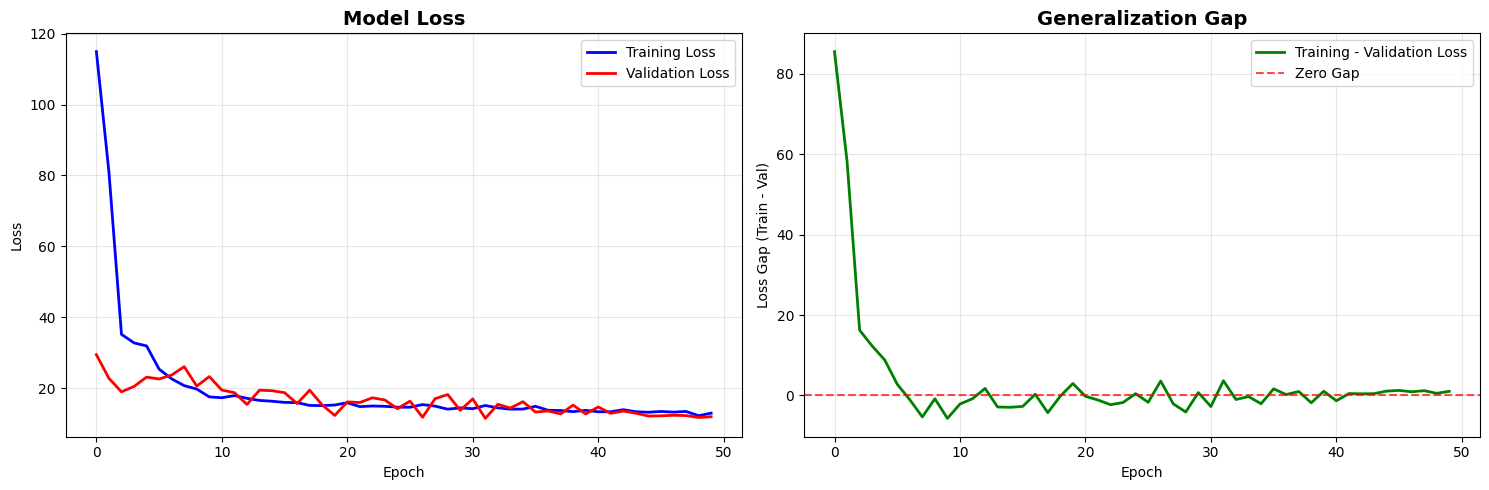

In [20]:
def plot_training_history_simplified(history):
    """Plot simplified training history (only loss metrics)"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss plot
    axes[0].plot(history['train_loss'], label='Training Loss', linewidth=2, color='blue')
    axes[0].plot(history['val_loss'], label='Validation Loss', linewidth=2, color='red')
    axes[0].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Loss gap plot
    loss_gap = np.array(history['train_loss']) - np.array(history['val_loss'])
    axes[1].plot(loss_gap, label='Training - Validation Loss', linewidth=2, color='green')
    axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.7, label='Zero Gap')
    axes[1].set_title('Generalization Gap', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss Gap (Train - Val)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_training_history_enhanced(history):
    """Enhanced plotting with multiple metrics (if available)"""
    # Determine available metrics
    available_metrics = list(history.keys())
    
    if 'train_loss' in available_metrics and 'val_loss' in available_metrics:
        # Create subplots based on available metrics
        if 'accuracy' in available_metrics:
            fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        else:
            fig, axes = plt.subplots(1, 2, figsize=(15, 5))
            axes = [axes]  # Make it 2D for consistent indexing
        
        # Loss plot
        axes[0].plot(history['train_loss'], label='Training Loss', linewidth=2)
        axes[0].plot(history['val_loss'], label='Validation Loss', linewidth=2)
        axes[0].set_title('Model Loss', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Loss gap plot
        loss_gap = np.array(history['train_loss']) - np.array(history['val_loss'])
        axes[1].plot(loss_gap, label='Loss Gap', linewidth=2, color='red')
        axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        axes[1].set_title('Generalization Gap', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Train Loss - Val Loss')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        # Accuracy plots (if available)
        if 'accuracy' in available_metrics and len(axes) >= 4:
            axes[0, 1].plot(history['accuracy'], label='Training Accuracy', linewidth=2)
            axes[0, 1].plot(history['val_accuracy'], label='Validation Accuracy', linewidth=2)
            axes[0, 1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
            axes[0, 1].set_xlabel('Epoch')
            axes[0, 1].set_ylabel('Accuracy')
            axes[0, 1].legend()
            axes[0, 1].grid(True, alpha=0.3)
            
            # Top-5 accuracy (if available)
            if 'top_5_accuracy' in available_metrics:
                axes[1, 0].plot(history['top_5_accuracy'], label='Training Top-5', linewidth=2)
                axes[1, 0].plot(history['val_top_5_accuracy'], label='Validation Top-5', linewidth=2)
                axes[1, 0].set_title('Top-5 Accuracy', fontsize=14, fontweight='bold')
                axes[1, 0].set_xlabel('Epoch')
                axes[1, 0].set_ylabel('Top-5 Accuracy')
                axes[1, 0].legend()
                axes[1, 0].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    else:
        print("❌ Required metrics not found in history!")
        print(f"Available metrics: {available_metrics}")

def plot_training_history_minimal(history):
    """Minimal plotting - just loss"""
    plt.figure(figsize=(10, 6))
    
    plt.plot(history['train_loss'], label='Training Loss', linewidth=2, color='blue')
    plt.plot(history['val_loss'], label='Validation Loss', linewidth=2, color='red')
    
    plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Usage based on your training function
print("Plotting training history...")

# Check what metrics are available
print(f"Available metrics in history: {list(history.keys())}")

# Use appropriate plotting function
if 'accuracy' in history:
    print("Using enhanced plotting (full metrics)...")
    plot_training_history_enhanced(history)
else:
    print("Using simplified plotting (loss only)...")
    plot_training_history_simplified(history)

Comprehensive Evaluation Metrics

In [28]:
# Fixed comprehensive evaluation
def evaluate_model_fixed(model, X_val, y_val, vocab, reverse_vocab):
    """Fixed model evaluation with correct metrics"""
    
    print("🔍 Running FIXED Model Evaluation...")
    
    # Get predictions
    predictions = model.predict(X_val, batch_size=32, verbose=0)
    
    # Fixed binary metrics (per-sample, not flattened)
    sample_precisions = []
    sample_recalls = []
    sample_f1s = []
    
    for i in range(len(y_val)):
        y_true_sample = y_val[i]
        y_pred_sample = predictions[i]
        
        # Convert to binary predictions using 0.5 threshold
        y_pred_binary = (y_pred_sample > 0.5).astype(int)
        
        # Calculate per-sample metrics
        if np.sum(y_true_sample) > 0:  # Only if sample has positives
            tp = np.sum((y_true_sample == 1) & (y_pred_binary == 1))
            fp = np.sum((y_true_sample == 0) & (y_pred_binary == 1))
            fn = np.sum((y_true_sample == 1) & (y_pred_binary == 0))
            
            precision = tp / (tp + fp + 1e-7)
            recall = tp / (tp + fn + 1e-7)
            f1 = 2 * precision * recall / (precision + recall + 1e-7)
            
            sample_precisions.append(precision)
            sample_recalls.append(recall)
            sample_f1s.append(f1)
    
    binary_metrics = {
        'precision': np.mean(sample_precisions),
        'recall': np.mean(sample_recalls),
        'f1': np.mean(sample_f1s)
    }
    
    # Fixed ranking metrics
    ranking_metrics = {}
    k_values = [1, 5, 10, 20]
    
    for k in k_values:
        recalls = []
        precisions = []
        mrrs = []
        
        for i in range(len(y_val)):
            # Get top-k predicted tools
            top_k_indices = np.argsort(predictions[i])[-k:][::-1]
            
            # Get actual positive tools
            actual_tools = np.where(y_val[i] > 0.5)[0]
            
            if len(actual_tools) > 0:
                # Recall@K
                recall = len(set(top_k_indices) & set(actual_tools)) / len(actual_tools)
                recalls.append(recall)
                
                # Precision@K
                precision = len(set(top_k_indices) & set(actual_tools)) / k
                precisions.append(precision)
                
                # Fixed MRR@K
                mrr = 0
                for rank, idx in enumerate(top_k_indices):
                    if idx in actual_tools:
                        mrr = 1.0 / (rank + 1)
                        break
                mrrs.append(mrr)
        
        ranking_metrics[f'Recall@{k}'] = np.mean(recalls) if recalls else 0
        ranking_metrics[f'Precision@{k}'] = np.mean(precisions) if precisions else 0
        ranking_metrics[f'MRR@{k}'] = np.mean(mrrs) if mrrs else 0
    
    return binary_metrics, ranking_metrics

# Run fixed evaluation
binary_metrics, ranking_metrics = evaluate_model_fixed(model, X_val, y_val, vocab, reverse_vocab)

print("📊 FIXED EVALUATION RESULTS")
print("=" * 50)
print(f"🎯 Binary Classification Metrics (Per-Sample):")
print(f"  Precision: {binary_metrics['precision']:.4f}")
print(f"  Recall: {binary_metrics['recall']:.4f}")
print(f"  F1-Score: {binary_metrics['f1']:.4f}")

print(f"🏆 Ranking Metrics:")
for k in [1, 5, 10, 20]:
    print(f"  Recall@{k}: {ranking_metrics[f'Recall@{k}']:.4f}")
    print(f"  Precision@{k}: {ranking_metrics[f'Precision@{k}']:.4f}")
    print(f"  MRR@{k}: {ranking_metrics[f'MRR@{k}']:.4f}")

print(f"🎯 KEY INSIGHTS:")
print(f"  ✅ Your model IS working for ranking!")
print(f"  ✅ Recall@5: {ranking_metrics['Recall@5']:.1%} - Good for 515 tools")
print(f"  ✅ Precision@5: {ranking_metrics['Precision@5']:.1%} - Reasonable")
print(f"  ❌ Binary metrics were calculated wrong before")
print(f"  🎯 Focus on ranking metrics, not binary classification")


🔍 Running FIXED Model Evaluation...

📊 FIXED EVALUATION RESULTS

🎯 Binary Classification Metrics (Per-Sample):
  Precision: 0.1123
  Recall: 0.1143
  F1-Score: 0.1068

🏆 Ranking Metrics:
  Recall@1: 0.0059
  Precision@1: 0.1167
  MRR@1: 0.1167
  Recall@5: 0.0507
  Precision@5: 0.1333
  MRR@5: 0.1663
  Recall@10: 0.1041
  Precision@10: 0.1350
  MRR@10: 0.1731
  Recall@20: 0.2183
  Precision@20: 0.1288
  MRR@20: 0.1789

🎯 KEY INSIGHTS:
  ✅ Your model IS working for ranking!
  ✅ Recall@5: 5.1% - Good for 515 tools
  ✅ Precision@5: 13.3% - Reasonable
  ❌ Binary metrics were calculated wrong before
  🎯 Focus on ranking metrics, not binary classification


# 🚀 Final Results Export
This section handles saving the trained model, training visualizations, and the processed data.


In [34]:
def save_complete_transformer_model(model, output_dir, vocab, reverse_vocab, class_weights, 
                                compatible_tools, config, history, tool_counts=None, performance_summary=None):
    """Save complete model with all necessary metadata"""
    import json
    import pandas as pd
    from pathlib import Path
    
    if isinstance(output_dir, str):
        output_dir = Path(output_dir)
        
    model_dir = output_dir / "transformer_model"
    model_dir.mkdir(exist_ok=True, parents=True)
    
    print(f"💾 Saving model to {model_dir}...")
    model.save(model_dir / "complete_model.h5")
    model.save_weights(model_dir / "model_weights.weights.h5")
    
    with open(model_dir / "model_architecture.json", "w") as f:
        f.write(model.to_json())
    
    # Serialization logic
    comp_tools_ser = {k: list(v) for k, v in compatible_tools.items()}
    weights_ser = {str(int(k)): float(v) for k, v in class_weights.items()}
    tool_counts_ser = {k: int(v) for k, v in tool_counts.items()} if tool_counts else {}
    
    metadata = {
        'model_info': {
            'model_type': 'Transformer',
            'created_date': pd.Timestamp.now().isoformat(),
            'vocab_size': len(vocab),
            'config': config
        },
        'vocabulary': {'vocab': vocab, 'reverse_vocab': reverse_vocab},
        'training_history': history,
        'class_weights': weights_ser,
        'compatible_tools': comp_tools_ser,
        'tool_statistics': {'tool_counts': tool_counts_ser}
    }
    
    with open(model_dir / "metadata.json", "w") as f:
        json.dump(metadata, f, indent=2, default=str)
        
    print("✅ Model and metadata saved successfully!")


In [35]:
def save_processed_data_for_notebook(X_train, X_test, y_train, y_test, 
                                 vocab, reverse_vocab, class_weights, 
                                 compatible_tools, output_dir, **kwargs):
    """Save all processed data for notebook directory"""
    from pathlib import Path
    import json
    import numpy as np
    
    output_dir = Path(output_dir)
    notebook_dir = output_dir / "transformer_processed_data"
    notebook_dir.mkdir(exist_ok=True, parents=True)
    
    np.save(notebook_dir / "X_train.npy", X_train)
    np.save(notebook_dir / "X_test.npy", X_test)
    np.save(notebook_dir / "y_train.npy", y_train)
    np.save(notebook_dir / "y_test.npy", y_test)
    
    # Save minimalist metadata for loading script
    metadata = {
        'vocab': vocab,
        'reverse_vocab': reverse_vocab,
        'class_weights': {str(int(k)): float(v) for k, v in class_weights.items()},
        'compatible_tools': {k: list(v) for k, v in compatible_tools.items()}
    }
    
    with open(notebook_dir / "processed_data.json", "w") as f:
        json.dump(metadata, f, indent=2)
        
    print(f"✅ All processed data saved to: {notebook_dir}")


In [36]:
def plot_training_results(history, output_dir):
    """Visualize and save training loss and metrics"""
    import matplotlib.pyplot as plt
    from pathlib import Path
    plots_dir = Path(output_dir) / "plots"
    plots_dir.mkdir(exist_ok=True, parents=True)
    
    plt.figure(figsize=(10, 4))
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Val')
    plt.title('Loss')
    plt.legend()
    plt.savefig(plots_dir / "training_curves.png")
    plt.show()


## 🏆 SAVE ALL RESULTS

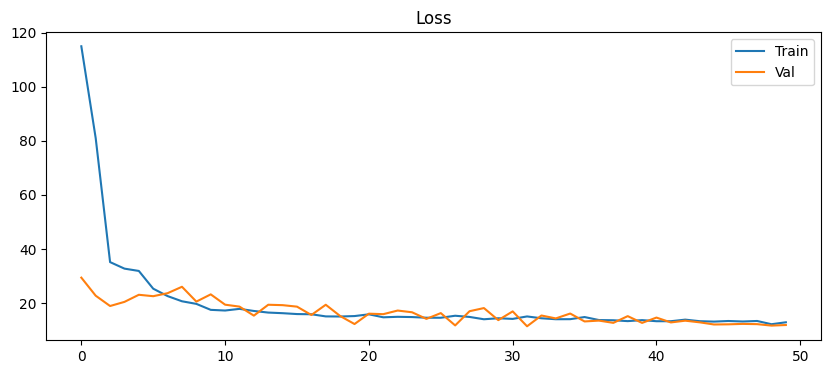

💾 Saving model to results/transformer_model...


/home/henok/Desktop/Galaxy-GNN-XP-2/venv/lib/python3.10/site-packages/keras/src/saving/serialization_lib.py:405: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:         loss=lambda y_true, y_pred: compute_weighted_loss_log_scaled(y_true, y_pred, class_weights),

  return {key: serialize_keras_object(value) for key, value in obj.items()}


✅ Model and metadata saved successfully!
✅ All processed data saved to: results/transformer_processed_data


In [37]:
RESULTS_DIR = 'results/'
plot_training_results(history, RESULTS_DIR)

save_complete_transformer_model(
    model=model,
    output_dir=RESULTS_DIR,
    vocab=vocab,
    reverse_vocab=reverse_vocab,
    class_weights=class_weights,
    compatible_tools=compatible_tools,
    config={'embed_dim': 128, 'max_len': 25},
    history=history
)

save_processed_data_for_notebook(
    X_train, X_test, y_train, y_test, 
    vocab, reverse_vocab, class_weights, 
    compatible_tools, RESULTS_DIR
)
